In [1]:
import random
import math
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
def draw_random_network(layers, edges, lastIdx):
    
    """
        Function draws a flow network.
        :param layers: it's a dictionary: keys represent number of each layer, values are a lists which contain indexes of vertices
        :param edges: it's a dictionary in which key is a tuple. It contains vertices which are ends of the edge. Value is a capacity of each edge.
        :param lastIdx: an integer which represent the index of sink.
        :return: None
    """
    
    nx_digraph = nx.DiGraph();
    labels = {}
    pos = {}
    x = 0
    y = 5
    counter = 0
    for elem in layers:
        for i in range(len(layers[elem])):
            nx_digraph.add_node(layers[elem][i])
            labels[layers[elem][i]] = layers[elem][i]
            if layers[elem][i] == 0 or layers[elem][i] == lastIdx:
                pos[layers[elem][i]] = (x, -5)
            else:
                if counter % 2 == 0:
                    if i == 0:
                        pos[layers[elem][i]] = (x, y*(-0.2)*2)
                    else:
                        pos[layers[elem][i]] = (x, y*i*2.25)
                else:
                    pos[layers[elem][i]] = (x, y*i)
        x = x + 20
        counter = counter + 1
        
    for elem in edges:
        nx_digraph.add_edge(elem[0], elem[1], weight = edges[elem])
    
    plt.figure(1, figsize=(12, 12))
    nx.draw(nx_digraph, pos=pos, linewidths=1, node_size=500, node_color='#08cbcf', alpha=0.95, labels=labels)
    nx.draw_networkx_edge_labels(nx_digraph, pos=pos, edge_labels=edges)
    plt.show()
    plt.clf()

In [3]:
def is_empty(graph, idx):
    
    """
        Function checks if the vertex is the end of the edge.
        :param graph: an array of arrays which represents flow network.
        :param idx: an integer which represents an index of vertex.
        :return isEmpty: a boolean which is True when the vertex isn't an end of any edge. Otherwise is False. 
    """
    
    isEmpty = True
    for i in range(len(graph)):
        if graph[i][idx] == 1:
            isEmpty = False
    return isEmpty

In [4]:
def is_any_empty(graph, layer):
    
    """
        Function checks if in the layer is any vertex which isn't an end of any edge.
        :param graph: an array of arrays which represents flow network.
        :param layer: an array which contains indexes of vertices inside layer.
        :return isAnyEmpty: boolean value: is True if in the layer is a vertex which isn't an end of any edge. Otherwise is False.
    """
    isAnyEmpty = False
    for elem in layer:
        isAnyEmpty = is_empty(graph, elem)
        if isAnyEmpty:
            break
    return isAnyEmpty

In [5]:
def create_random_flow_network(N):
    
    """
        Function creates random flow network. Flow network is encoded in the form of neighbourhoud matrix.
        :param N: an integer which represents a number of layers between source and sink.
        :return (graph, layers, edges): tuple contains graph which is an array of arrays - this matrix encode flow network. Tuple also contains
                        layers, which is a dictionary: keys represent number of each layer, values are a lists which contain indexes of vertices.
                        The last element is edges which is a dictionary in which key is a tuple. 
                        It contains vertices which are ends of the edge. Value is a capacity of each edge.

    """
    
    if N < 2:
        return None, None, None
    
    # tablica przechowująca ilość wierzchołków w każdej z warstw pośrednich
    numberOfVerticesInEachLayer = []
    # dodanie losowej liczby wierzchołków z przedziału [2, N]
    for i in range(N):
        numberOfVerticesInEachLayer.append(random.randint(2, N))
    # sumowanie liczby wierzchołków pośrednich, źródła i ujśćia
    numberOfVertices = sum(numberOfVerticesInEachLayer) + 2
    # utworzenie macierzy sąsiedztwa odpowiadającej warunkom zadania 
    graph = [[0 for i in range(numberOfVertices)] for j in range(numberOfVertices)]
    # słownik przechowujący listy numerów wierzchołków w poszczególnych warstwach
    # klucz jest numerem warstwy, wartość to tablica z indeksami wierzchołków
    layers = {}
    # przypisanie źródła
    layers[0] = [0]
    # utworzenie pustych tablic dla warstw pośrednich
    for i in range(1, N+1):
        layers[i] = []
    layers[N+1] = [numberOfVertices-1]
    tmp = 1
    iter = 0
    # przypisanie kolejnych indeksów w warstwach pośrednich
    for i in range(N):
        while iter < numberOfVerticesInEachLayer[i]:
            layers[i+1].append(tmp)
            tmp = tmp + 1
            iter = iter + 1
        iter = 0
    #print(layers)
    # łączenie źródła z warstwą 1 (do każdego wierzchołka warstwy 1 musi wchodzić krawędź)
    for elem in layers.get(1):
        graph[0][elem] = 1
    # łączenie przedostatniej warstwy z ujściem
    for elem in layers.get(N):
        graph[elem][numberOfVertices-1] = 1
    # przejście przez warstwy pośrednie
    for i in range(1, N+1):
        for j in range(len(layers.get(i))):
            nextLayerIdx = i+1
            tmp = random.choice(layers.get(nextLayerIdx))
            # sprawdzenie czy coś wchodzi do wylosowanego wierzchołka
            while not is_empty(graph, tmp):
                # następuje sprawdzenie czy jest jeszcze jakiś wierzchołek, do którego nic nie wchodzi w tej warstwie
                if not is_any_empty(graph, layers.get(nextLayerIdx)):
                    break
                tmp = random.choice(layers.get(nextLayerIdx))
            graph[layers.get(i)[j]][tmp] = 1
            
            # ostatni wierzchołek warstwy obecnej i przypadek większej ilości wierzchołków w następnej warstwie
            # trzeba dołożyć dodatkową krawędź do wierzchołka w warstwie następnej, do którego nie wchodzi do tej pory żadna krawędź
            if j == len(layers.get(i))-1 and len(layers.get(nextLayerIdx)) > len(layers.get(i)):
                while is_any_empty(graph, layers.get(nextLayerIdx)):
                    tmp = random.choice(layers.get(nextLayerIdx))
                    if is_empty(graph, tmp):
                        graph[layers.get(i)[j]][tmp] = 1
                        
    # zmienna zliczająca dodane krawędzie
    iter = 0
    # ograniczenie na dodanie 2*N krawędzi
    while iter < 2*N:
        # losowanie wierzchołków do połączenia 
        # granice losowania zabezpieczają przed wylosowaniem krawędzi wchodzącej do źródła lub wychodzącej z ujścia
        firstIdx = random.randint(0, numberOfVertices-2)
        secondIdx = random.randint(1, numberOfVertices-1)
        # sprawdzenie czy nie występuje pętla, krawędź skierowana przeciwnie, lub czy już nie ma takiej krawędzi
        while firstIdx == secondIdx or graph[secondIdx][firstIdx] == 1 or graph[firstIdx][secondIdx] == 1:
            firstIdx = random.randint(0, numberOfVertices-2)
            secondIdx = random.randint(1, numberOfVertices-1)
        # dodanie wylosowanej krawędzi
        graph[firstIdx][secondIdx] = 1
        iter = iter + 1
    
    iter = 0
    # przypisanie przepustowości do krawędzi
    for i in range(numberOfVertices):
        for j in range(numberOfVertices):
            if graph[i][j] == 1:
                graph[i][j] = random.randint(1, 10)
                iter = iter + 1
    #print(graph)
    edges = {}
    for i in range(numberOfVertices):
        for j in range(numberOfVertices):
            if graph[i][j] != 0:
                edges[(i,j)] = graph[i][j]
    
    return graph, layers, edges

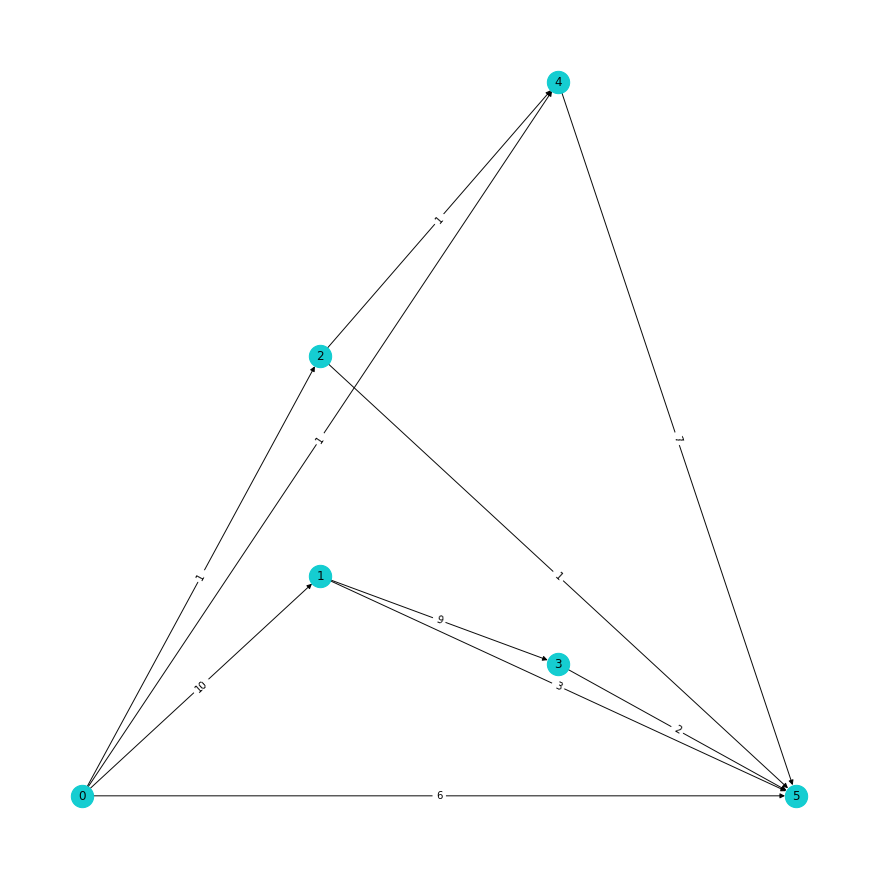

<Figure size 432x288 with 0 Axes>

In [6]:
pack = create_random_flow_network(2)
draw_random_network(pack[1], pack[2], len(pack[0])-1)

In [7]:
def BFS(graph):
    
    """
        Function is an implementation of BFS algorithm.
        :param graph:  an array of arrays which represents flow network.
        :return track: an array of integers which represents indexes of vertices.
    """
    
    if graph == None:
        return []
    distances = []
    predecessors = []
    for i in range(len(graph)):
        distances.append(math.inf)
        predecessors.append(None)
    distances[0] = 0
    queue = []
    queue.append(0)
    while len(queue) > 0:
            v = queue.pop(0)
            for i in range(len(graph)):
                if graph[v][i] != 0 and distances[i] == math.inf:
                    distances[i] = distances[v] + 1
                    predecessors[i] = v
                    queue.append(i)
    track = []
    track.insert(0, len(graph)-1)
    idx = len(graph)-1
    while predecessors[idx] != None:
        idx = predecessors[idx]
        track.insert(0, idx)
    if len(track) == 1:
        track = []
    return track

In [8]:
pack = create_random_flow_network(2)
BFS(pack[0])

[0, 2, 5]

In [9]:
def draw_max_flow(layers, edges, flow, lastIdx):
    
    """
        Function draws a flow network and color edges which have greater the zero flow.
        :param layers: it's a dictionary: keys represent number of each layer, values are a lists which contain indexes of vertices
        :param edges: it's a dictionary in which key is a tuple. It contains vertices which are ends of the edge. Value is a capacity of each edge.
        :param flow: it's a dictionary in which key is a tuple. It contains vertices which are ends of the edge. Value is an integer which represents a flow in each edge.
        :param lastIdx: an integer which represent the index of sink.
        :return: None
    """
    
    if layers == None or edges == None or flow == None or lastIdx == None:
        return
    nx_digraph = nx.DiGraph();
    labels = {}
    pos = {}
    edge_labels = {}
    edge_colors = []
    x = 0
    y = 5
    counter = 0
    for elem in layers:
        for i in range(len(layers[elem])):
            nx_digraph.add_node(layers[elem][i])
            labels[layers[elem][i]] = layers[elem][i]
            if layers[elem][i] == 0 or layers[elem][i] == lastIdx:
                pos[layers[elem][i]] = (x, -5)
            else:
                if counter % 2 == 0:
                    if i == 0:
                        pos[layers[elem][i]] = (x, y*(-0.2)*2)
                    else:
                        pos[layers[elem][i]] = (x, y*i*2.25)
                else:
                    pos[layers[elem][i]] = (x, y*i)
        x = x + 20
        counter = counter + 1
        
    for elem in edges:
        if flow[elem] > 0:
            edge_colors.append('red')
        else:
            edge_colors.append('black')
        nx_digraph.add_edge(elem[0], elem[1], weight = edges[elem])
        edge_labels[elem] = str(flow[elem]) + '/' + str(edges[elem])
    
    plt.figure(1, figsize=(12, 12))
    plt.rcParams.update({'font.size': 42})
    nx.draw(nx_digraph, pos=pos, edge_color = edge_colors, linewidths=1, node_size=500, node_color='#08cbcf', alpha=0.95, labels=labels)
    nx.draw_networkx_edge_labels(nx_digraph, pos=pos, edge_labels=edge_labels)
    plt.show()
    plt.clf()

In [10]:
def Ford_Fulkerson(pack):
    
    """
        Function is an implementation of Ford_Fulkersom algorithm. It looks for the max flow in passed flow network.
        This function finds the max flow, plots the flow network and prints out the value of the max flow.
        :param pack: it's a tuple which contains graph, layers, edges. Tuple contains graph which is an array of arrays - this matrix encode flow network. Tuple also contains
                     layers, which is a dictionary: keys represent number of each layer, values are a lists which contain indexes of vertices.
                     The last element is edges which is a dictionary in which key is a tuple. 
                     It contains vertices which are ends of the edge. Value is a capacity of each edge.
        :return: None
        
    """
    
    if pack[0] == None:
        return
    graph = pack[0]
    residuum = [row[:] for row in graph]
    flow = {}
    for i in range(len(residuum)):
        for j in range(len(residuum)):
            if graph[i][j] != 0:
                flow[(i,j)] = 0
    track = BFS(residuum)
    while len(track) > 0:
        min = 11
        for j in range(len(track)-1):
            if residuum[track[j]][track[j+1]] < min:
                min = residuum[track[j]][track[j+1]]
        for j in range(len(track)-1):
            if graph[track[j]][track[j+1]] != 0:
                flow[(track[j],track[j+1])] = flow[(track[j],track[j+1])] + min
                residuum[track[j]][track[j+1]] = residuum[track[j]][track[j+1]] - min
                if residuum[track[j]][track[j+1]] == 0:
                    residuum[track[j+1]][track[j]] = min
            else:
                flow[(track[j+1],track[j])] = flow[(track[j+1],track[j])] - min
                residuum[track[j]][track[j+1]] = residuum[track[j]][track[j+1]] - min
                if residuum[track[j]][track[j+1]] == 0:
                    residuum[track[j+1]][track[j]] = min
        track = BFS(residuum)
    
    maxFlow = 0
    for elem in flow:
        if elem[1] == len(graph)-1:
            maxFlow = maxFlow + flow[elem]

    draw_max_flow(pack[1], pack[2], flow, len(graph)-1)
    print("Maksymalny przepływ na sieci wynosi: " + str(maxFlow) + ".")

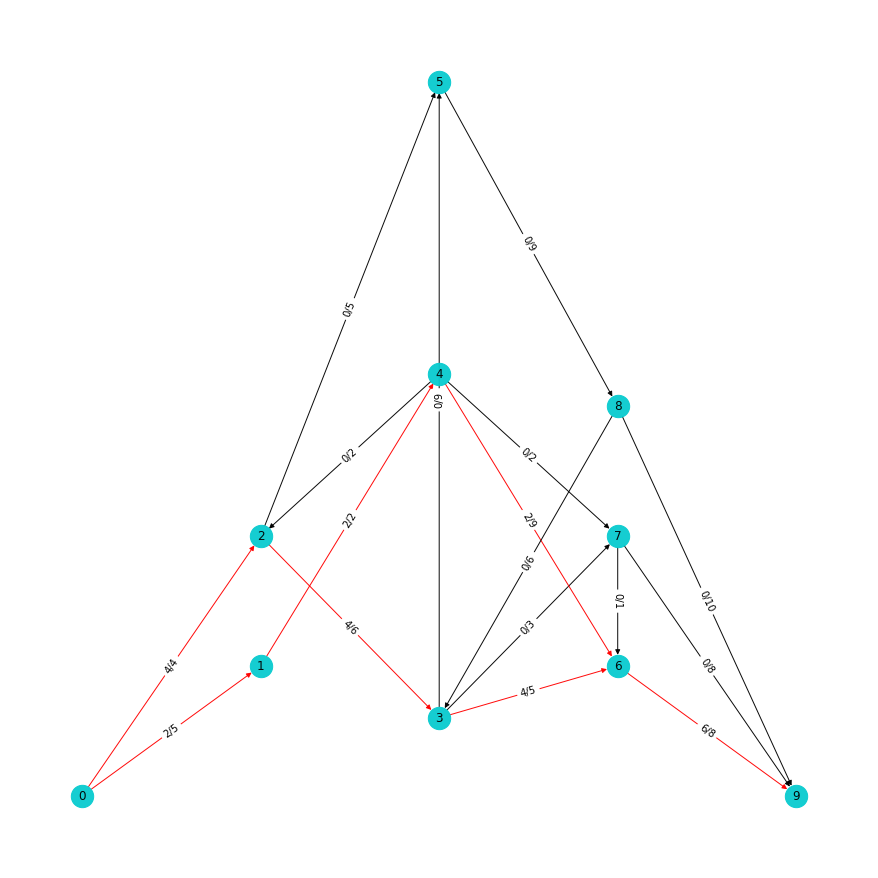

Maksymalny przepływ na sieci wynosi: 6.


<Figure size 432x288 with 0 Axes>

In [11]:
pack = create_random_flow_network(3)
Ford_Fulkerson(pack)